In [59]:
import pandas as pd
import numpy as np

listings = pd.read_csv("en_sent_merged.csv")

X = pd.DataFrame(listings, columns = ['id','sentiment', 'comments'])
X.head()

/var/folders/rd/j5mq0pcd6c3b6ld8pnmj2xnw0000gn/T/ipykernel_12460/679911019.py:4: DtypeWarning: Columns (1,3,10,36,45,46,55,62,64,65,66) have mixed types. Specify dtype option on import or set low_memory=False.
  listings = pd.read_csv("en_sent_merged.csv")


,id,sentiment,comments
0,44077,0.9513,we enjoyed our stay very much. the room was co...
1,44077,0.9804,we have been here 4 nights. stay in a home is ...
2,44077,0.9836,teresa and hughie were great hosts. they were ...
3,44077,0.9447,no surprises was as described. very gracious h...
4,44077,0.9821,teresa was a lovely hostess and we had a delig...


In [60]:
apposV2 = {
"are not" : "are not",
"ca" : "can",
"could n't" : "could not",
"did n't" : "did not",
"does n't" : "does not",
"do n't" : "do not",
"had n't" : "had not",
"has n't" : "has not",
"have n't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"is n't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"might n't" : "might not",
"must n't" : "must not",
"sha" : "shall",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"should n't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"were n't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"wo" : "will",
"would n't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"was n't": "was not",
"we'll":"we will",
"did n't": "did not"
}
appos = {
"aren't" : "are not",
"can't" : "cannot",
"couldn't" : "could not",
"didn't" : "did not",
"doesn't" : "does not",
"don't" : "do not",
"hadn't" : "had not",
"hasn't" : "has not",
"haven't" : "have not",
"he'd" : "he would",
"he'll" : "he will",
"he's" : "he is",
"i'd" : "I would",
"i'd" : "I had",
"i'll" : "I will",
"i'm" : "I am",
"isn't" : "is not",
"it's" : "it is",
"it'll":"it will",
"i've" : "I have",
"let's" : "let us",
"mightn't" : "might not",
"mustn't" : "must not",
"shan't" : "shall not",
"she'd" : "she would",
"she'll" : "she will",
"she's" : "she is",
"shouldn't" : "should not",
"that's" : "that is",
"there's" : "there is",
"they'd" : "they would",
"they'll" : "they will",
"they're" : "they are",
"they've" : "they have",
"we'd" : "we would",
"we're" : "we are",
"weren't" : "were not",
"we've" : "we have",
"what'll" : "what will",
"what're" : "what are",
"what's" : "what is",
"what've" : "what have",
"where's" : "where is",
"who'd" : "who would",
"who'll" : "who will",
"who're" : "who are",
"who's" : "who is",
"who've" : "who have",
"won't" : "will not",
"wouldn't" : "would not",
"you'd" : "you would",
"you'll" : "you will",
"you're" : "you are",
"you've" : "you have",
"'re": " are",
"wasn't": "was not",
"we'll":" will",
"didn't": "did not"
}

In [61]:
import re
import nltk.data
import string
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
def clean(review):
    letters_only = BeautifulSoup(review).get_text()
    letters_only = letters_only.replace(" n't"," not")
    letters_only = letters_only.replace("."," . ")
    letters_only = ' '.join(word.strip(string.punctuation) for word in letters_only.split())
    letters_only = re.sub('[^a-zA-Z0-9]', ' ', letters_only)
    letters_only = letters_only.lower()
    words = letters_only.split()
    words = [w for w in words if w not in stop_words]
    split = [apposV2[word] if word in apposV2 else word for word in words] #correct using apposV2 as mentioned above
    split = [appos[word] if word in appos else word for word in split] #correct using appos as mentioned above
    return " ".join(split)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pallavit/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [62]:
from tqdm import tqdm
from bs4 import BeautifulSoup
all_reviews = []
for review in tqdm(X['comments']):
    review = str(review)
    if(len(review)>3):
        all_reviews.append(clean(review))

100%|█████████████████████████████████| 203317/203317 [00:46<00:00, 4354.42it/s]


In [63]:
X = X.assign(
    sent_bins = pd.cut(
        X['sentiment'],
        bins=[-1, 0, 0.5, 1],
        duplicates='drop',
        labels=[0,1,2]
    )
)

In [64]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import GridSearchCV, cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score

lr = LogisticRegression(random_state=1, max_iter=10000)

In [65]:
X.dropna(subset=['id', 'comments'], inplace=True)

In [66]:
X_train = X['comments']
y_train = X['sent_bins']

In [51]:
X_train.isna().sum()

0

In [38]:
from sklearn.feature_extraction.text import CountVectorizer
# initalise the vectoriser 
cvec = CountVectorizer()
# fit the training data on the model
cvec.fit(X_train)

#transform training data into sparse matrix
X_train_cvec = cvec.transform(X_train)

# cross val score/ predict
cvec_score = cross_val_score(lr, X_train_cvec, y_train, cv=3)
X_train_cvec

<203297x40151 sparse matrix of type '<class 'numpy.int64'>'
	with 6790301 stored elements in Compressed Sparse Row format>

In [40]:
from sklearn.feature_extraction.text import TfidfVectorizer
# initalise the vectoriser 
tvec = TfidfVectorizer()
# fit the training data on the model
tvec.fit(X_train)

#transform training data into sparse matrix
X_train_tvec = tvec.transform(X_train)

# cross val score/ predict
tvec_score = cross_val_score(lr, X_train_tvec, y_train, cv=3)

In [67]:
print('Tfidf Vectorizer Score:', tvec_score.mean())
print('Count Vectorizer Score:', cvec_score.mean())

Tfidf Vectorizer Score: 0.9511797933809837
Count Vectorizer Score: 0.961529185255102


In [58]:
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

def count_vec_ngram(params, X_train, y_train):
    cvec_p = CountVectorizer(ngram_range=(params))
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=2)
    # cross validation 
    return cvec_score_p.mean()

params = [(1,1), (1,2), (1,3)] 
ngram_scores = []
for p in params:
    ngram_scores.append(count_vec_ngram(p, X_train, y_train))
    
ngrams = ['cvec gram_1','cvec gram_2','cvec gram_3']
ngram_df = pd.DataFrame({'params':ngrams, 'scores':ngram_scores}, index=[0,1,2])
# adding cvec score with default params
ngram_df = ngram_df.append(acc_df.iloc[:1,:])
# plot scores on graph
sns.pointplot(x='params', y='scores', data =ngram_df)
plt.ylabel('Accuracy Score')
plt.xlabel('ngrams')
plt.xticks(rotation=40)
plt.show()

KeyboardInterrupt: 

In [68]:
acc_list = []
acc_list.append(cvec_score.mean())
acc_list.append(tvec_score.mean())
acc_df = pd.DataFrame()
acc_df['params']= ['cvec', 'tvec']
acc_df['scores']= acc_list

/var/folders/rd/j5mq0pcd6c3b6ld8pnmj2xnw0000gn/T/ipykernel_12460/1241209662.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  max_features_df = max_features_df.append(acc_df.iloc[:1,:])


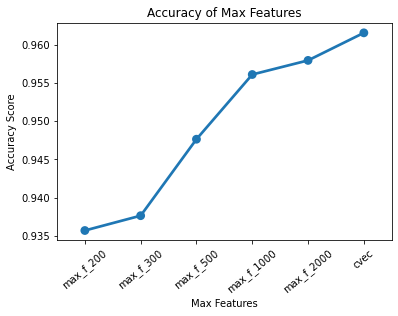

In [70]:
def count_vec_max_features(params, X_train, y_train):
    cvec_p = CountVectorizer(max_features=params)
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
# cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=2)
# cross validation 
    return cvec_score_p.mean()
mf_params = [200, 300, 500, 1000, 2000]
max_features_scores = [count_vec_max_features(p, X_train, y_train) for p in mf_params]
max_features = ['max_f_'+str(p) for p in mf_params]
# dataframe for scores
max_features_df = pd.DataFrame({'params':max_features, 'scores':max_features_scores}, index=[0,1,2,3,4])
# adding cvec score with default params
max_features_df = max_features_df.append(acc_df.iloc[:1,:])
sns.pointplot(x='params', y='scores', data =max_features_df)
plt.ylabel('Accuracy Score')
plt.xlabel('Max Features')
plt.xticks(rotation=40)
plt.title('Accuracy of Max Features')
plt.show()

/var/folders/rd/j5mq0pcd6c3b6ld8pnmj2xnw0000gn/T/ipykernel_12460/2352747631.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  max_df_df = max_df_df.append(acc_df.iloc[:1,:])


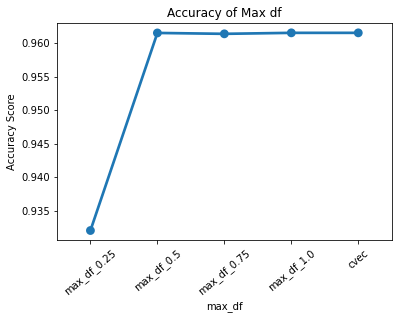

In [69]:
def count_vec_max_df(params, X_train, y_train):
    cvec_p = CountVectorizer(max_df=params)
    cvec_p.fit(X_train)
    X_train_cvec_p = cvec_p.transform(X_train)
    # cross val score/ predict
    cvec_score_p = cross_val_score(lr, X_train_cvec_p, y_train, cv=3)
    # cross validation 
    return cvec_score_p.mean()
mdf_params = [0.25, 0.5, 0.75, 1.0]
max_df_scores = [count_vec_max_df(p, X_train, y_train) for p in mdf_params]
max_df = ['max_df_'+str(p) for p in mdf_params]
# dataframe for scores
max_df_df = pd.DataFrame({'params':max_df, 'scores':max_df_scores}, index=[0,1,2,3])
# adding cvec score with default params
max_df_df = max_df_df.append(acc_df.iloc[:1,:])
sns.pointplot(x='params', y='scores', data =max_df_df)
plt.ylabel('Accuracy Score')
plt.xlabel('max_df')
plt.xticks(rotation=40)
plt.title('Accuracy of Max df')
plt.show()

In [72]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
cfvectorizer = CountVectorizer(analyzer='word', ngram_range=(1, 2), max_df=0.50, max_features=1000)
reviews_tfidf = cfvectorizer.fit_transform(X_train)
reviews_tfidf = reviews_tfidf.toarray()

In [73]:
reviews_tfidf = pd.DataFrame(data=reviews_tfidf)

In [74]:
reviews_tfidf.columns = ['tfidf_' + str(x) for x in range(1000)]

In [75]:
reviews_tfidf.head()

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_990,tfidf_991,tfidf_992,tfidf_993,tfidf_994,tfidf_995,tfidf_996,tfidf_997,tfidf_998,tfidf_999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [76]:
reviews_tfidf['id'] = X['id']

In [77]:
reviews_tfidf['sentiment'] = X['sentiment']

In [80]:
reviews_tfidf.head()

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_993,tfidf_994,tfidf_995,tfidf_996,tfidf_997,tfidf_998,tfidf_999,id,sentiment,sent_bins
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,44077,0.9513,2
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,44077,0.9804,2
2,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,44077,0.9836,2
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,44077,0.9447,2
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,44077,0.9821,2


In [79]:
reviews_tfidf['sent_bins'] = X['sent_bins']

In [90]:
reviews_tfidf.sent_bins = pd.to_numeric(reviews_tfidf.sent_bins)

In [91]:
reviews_tfidf.dtypes

tfidf_0        int64
tfidf_1        int64
tfidf_2        int64
tfidf_3        int64
tfidf_4        int64
              ...   
tfidf_998      int64
tfidf_999      int64
id            object
sentiment    float64
sent_bins    float64
Length: 1003, dtype: object

In [100]:
temp = reviews_tfidf.groupby('id')['sentiment','sent_bins'].median().reset_index()
#temp['listing_id'] = listing_ids
for i in tqdm(range(0, 1000, 5)):
    col = ['tfidf_' + str(x) for x in range(i, i+5)]
    temp = temp.merge(reviews_tfidf.groupby('id')[col].mean().reset_index(), on='id', how='inner')

/var/folders/rd/j5mq0pcd6c3b6ld8pnmj2xnw0000gn/T/ipykernel_12460/753053880.py:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  temp = reviews_tfidf.groupby('id')['sentiment','sent_bins'].median().reset_index()
100%|█████████████████████████████████████████| 200/200 [00:21<00:00,  9.15it/s]


In [137]:
temp.head()

,id,sentiment,sent_bins,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,...,tfidf_990,tfidf_991,tfidf_992,tfidf_993,tfidf_994,tfidf_995,tfidf_996,tfidf_997,tfidf_998,tfidf_999
0,44077,0.9456,2,0.055300,0.000000,0.000000,0.092166,0.027650,0.018433,0.018433,...,0.221198,0.000000,0.000000,0.023041,0.009217,0.004608,0.004608,0.004608,0.004608,0.000000
1,85156,0.9535,2,0.052326,0.000000,0.011628,0.081395,0.023256,0.005814,0.017442,...,0.191860,0.005814,0.000000,0.011628,0.000000,0.000000,0.000000,0.000000,0.005814,0.000000
2,159889,0.9116,2,0.059748,0.003145,0.000000,0.053459,0.050314,0.009434,0.025157,...,0.100629,0.000000,0.012579,0.003145,0.003145,0.003145,0.003145,0.003145,0.006289,0.000000
3,162809,0.9280,2,0.036765,0.011029,0.000000,0.014706,0.033088,0.014706,0.025735,...,0.084559,0.000000,0.003676,0.007353,0.003676,0.003676,0.014706,0.011029,0.018382,0.011029
4,165828,0.9175,2,0.102041,0.020408,0.000000,0.081633,0.081633,0.000000,0.000000,...,0.163265,0.020408,0.020408,0.020408,0.081633,0.000000,0.061224,0.000000,0.000000,0.000000


<AxesSubplot:>

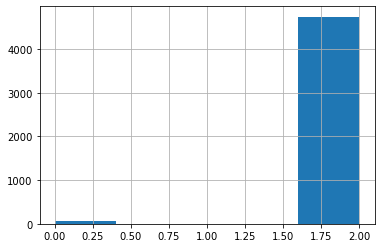

In [140]:
temp['sent_bins'].hist(bins=5)

In [144]:
temp.to_csv("vect_file.csv")

In [139]:
temp = temp.assign(
    sent_bins = pd.cut(
        temp['sent_bins'],
        bins=[0, 1, 1.75, 2],
        duplicates='drop',
        labels=[0,1,2]
    )
)

In [141]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler 
scaler = StandardScaler()
G = pd.DataFrame(scaler.fit_transform(temp), columns=list(temp.columns))
G=G.reset_index()
X_train = G.drop(labels=['id','sent_bins','index'],axis=1)
y_train = G['sent_bins']

In [126]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [142]:
X_train = clean_dataset(X_train)

In [136]:
X_train.dtypes

index          int64
sentiment    float64
tfidf_0      float64
tfidf_1      float64
tfidf_2      float64
              ...   
tfidf_995    float64
tfidf_996    float64
tfidf_997    float64
tfidf_998    float64
tfidf_999    float64
Length: 1002, dtype: object

In [143]:
# from sklearn.preprocessing import StandardScaler, MinMaxScaler 
# scaler = StandardScaler()
# G = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))
# from sklearn import preprocessing
# from sklearn import utils
# #convert y values to categorical values
# lab = preprocessing.LabelEncoder()
# y_train = lab.fit_transform(y_train)
# X_train = lab.fit_transform(X_train)
X_train = X_train.reset_index()
tvec_score = cross_val_score(lr, X_train, y_train, cv=3)

ValueError: Input contains NaN, infinity or a value too large for dtype('float64').

In [121]:
np.any(np.isnan(X_train))

False

In [124]:
np.all(np.isfinite(X_train))

True